<a href="https://colab.research.google.com/github/SamwelJane/Customers-behaviour/blob/master/Clustering_and_MBA_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # RESEARCH OBJECTIVE

To find the relationship between purchases

# Metrics of success
To successfully identify goods that are purchased together using the association analysis technique.

# Context

We shall use online shopping data for the years 2009 to 2010 for retail customers

# Experimental design
 Data sourcing and loading

Data cleaning

Feature Engineering

EDA

Defining the rules and use the Apriori algorithms for extracting frequent item sets for further analysis.

Drawing insights

# Appropriateness of Data

The data was appropriate in terms of volume and relevance to our study


In [0]:
# Libraries imported
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
# loading the dataset and previwe the last 5 rows
retail = pd.read_excel('/content/online_retail_II.xlsx', sheet_name='Year 2009-2010')
retail.head()
retail.tail()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530.0,United Kingdom
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530.0,United Kingdom
525460,538171,21931,JUMBO STORAGE BAG SUKI,2,2010-12-09 20:01:00,1.95,17530.0,United Kingdom


# Exploratory Data Analysis

In [0]:
# displaying information about the dataset (i.e. datatype and no. of missing values)
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
Invoice        525461 non-null object
StockCode      525461 non-null object
Description    522533 non-null object
Quantity       525461 non-null int64
InvoiceDate    525461 non-null datetime64[ns]
Price          525461 non-null float64
Customer ID    417534 non-null float64
Country        525461 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


In [0]:
# dataset shape
retail.shape

(525461, 8)

In [0]:
# displaying value counts of the description column to determine no. of products and most common goods
retail['Description'].value_counts()

# there are about 4681 unique products 

WHITE HANGING HEART T-LIGHT HOLDER    3549
REGENCY CAKESTAND 3 TIER              2212
STRAWBERRY CERAMIC TRINKET BOX        1843
PACK OF 72 RETRO SPOT CAKE CASES      1466
ASSORTED COLOUR BIRD ORNAMENT         1457
                                      ... 
CAMOFLAGE CUSHION COVER                  1
ENGLISH ROSE SQUARE CAKE TINS            1
S/6 SCANDINAVIAN HEART T-LIGHT           1
HAND OPEN SHAPE CHROME                   1
mouldy                                   1
Name: Description, Length: 4681, dtype: int64

In [0]:
# adding new columns (i.e. 4) to the dataframe to facilitate better analysis
# the columns are derived from invoicedate column

retail['totalAmount'] = retail['Quantity'] * retail['Price']
retail['InvoiceYear'] = retail['InvoiceDate'].dt.year
retail['InvoiceMonth'] = retail['InvoiceDate'].dt.month
retail['InvoiceYearMonth'] = retail['InvoiceYear'].map(str) + "-" + retail['InvoiceMonth'].map(str)

In [0]:
# previewing the first five observations after addition of new columns
retail.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,totalAmount,InvoiceYear,InvoiceMonth,InvoiceYearMonth
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4,2009,12,2009-12
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,2009,12,2009-12
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,2009,12,2009-12
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8,2009,12,2009-12
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0,2009,12,2009-12


In [0]:
# getting the length/no. of unique values in the invoice column
len(retail['Invoice'].unique())

28816

In [0]:
# checking for the number of unique values with null customer id
len(retail[retail['Customer ID'].isnull()]['Invoice'].unique())

5229

In [0]:
# displaying the no. of customers
len(retail['Customer ID'].unique())

4384

In [0]:
# getting the total amount of goods sold
sum(retail['totalAmount'])

9539484.63400263

In [0]:
#  list of columnsw with price less than zero
display(retail[retail['Price'] < 0])



,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,totalAmount,InvoiceYear,InvoiceMonth,InvoiceYearMonth
179403,A506401,B,Adjust bad debt,1,2010-04-29 13:36:00,-53594.36,NaN,United Kingdom,-53594.36,2010,4,2010-4
276274,A516228,B,Adjust bad debt,1,2010-07-19 11:24:00,-44031.79,NaN,United Kingdom,-44031.79,2010,7,2010-7
403472,A528059,B,Adjust bad debt,1,2010-10-20 12:04:00,-38925.87,NaN,United Kingdom,-38925.87,2010,10,2010-10


In [0]:
# determine no. of entries with quantity and price <= 0
display(retail[(retail.Quantity <= 0) & (retail.Price <= 0)].shape[0])

# 2121 entries have either quantity or price <= 0

2121

In [0]:

# determine entries where price = 0 and customer id is not null
retail[(retail.Price==0)  & ~(retail['Customer ID'].isnull())]

display(retail[(retail.Price == 0)  & ~(retail['Customer ID'].isnull())].shape[0])

# 31 entries have price = 0 and a valid customer id

31

In [0]:
# total number of missing values in  customer id
retail[retail['Customer ID'].isnull()].shape[0]

107927

In [0]:
# declaring a function rstr that will help display the statistics of dataframes in a desired format
# resulting table will display no. of observations, datatypes, unique values, skewness, kurtosis etc.

def rstr(df, pred=None): 
    obs = df.shape[0]
    types = df.dtypes
    counts = df.apply(lambda x: x.count())
    uniques = df.apply(lambda x: [x.unique()])
    nulls = df.apply(lambda x: x.isnull().sum())
    distincts = df.apply(lambda x: x.unique().shape[0])
    missing_ration = (df.isnull().sum()/ obs) * 100
    skewness = df.skew()
    kurtosis = df.kurt() 
    print('Data shape:', df.shape)
    
    if pred is None:
        cols = ['types', 'counts', 'distincts', 'nulls', 'missing ration', 'uniques', 'skewness', 'kurtosis']
        str = pd.concat([types, counts, distincts, nulls, missing_ration, uniques, skewness, kurtosis], axis = 1, sort=True)

    else:
        corr = df.corr()[pred]
        str = pd.concat([types, counts, distincts, nulls, missing_ration, uniques, skewness, kurtosis, corr], axis = 1, sort=True)
        corr_col = 'corr '  + pred
        cols = ['types', 'counts', 'distincts', 'nulls', 'missing ration', 'uniques', 'skewness', 'kurtosis', corr_col ]
    
    str.columns = cols
    dtypes = str.types.value_counts()
    print('___________________________\nData types:\n',str.types.value_counts())
    print('___________________________')
    return str


In [0]:
# !pip install rstr
# import rstr

# creating a new dataframe that has no null values in the customer id column.
retail_cl = retail[~(retail['Customer ID'].isnull())]


# Remove negative or return transactions
retail_cl = retail_cl[~(retail_cl.Quantity < 0)]
retail_cl = retail_cl[retail_cl.Price > 0]

# passing dataframe to rstr function to display statistics of the dataframe
details = rstr(retail_cl)

display(details.sort_values(by='distincts', ascending=False))

Data shape: (407664, 12)
___________________________
Data types:
 object            5
float64           3
int64             3
datetime64[ns]    1
Name: types, dtype: int64
___________________________


,types,counts,distincts,nulls,missing ration,uniques,skewness,kurtosis
Invoice,object,407664,19213,0,0.0,"[[489434, 489435, 489436, 489437, 489438, 4894...",-0.104385,-1.204806
InvoiceDate,datetime64[ns],407664,18008,0,0.0,"[[2009-12-01 07:45:00, 2009-12-01 07:46:00, 20...",NaN,NaN
Description,object,407664,4444,0,0.0,"[[15CM CHRISTMAS GLASS BALL 20 LIGHTS, PINK CH...",NaN,NaN
Customer ID,float64,407664,4312,0,0.0,"[[13085.0, 13078.0, 15362.0, 18102.0, 12682.0,...",-0.021961,-1.188627
StockCode,object,407664,4017,0,0.0,"[[85048, 79323P, 79323W, 22041, 21232, 22064, ...",NaN,NaN
totalAmount,float64,407664,2529,0,0.0,"[[83.4, 81.0, 100.80000000000001, 30.0, 39.599...",58.612573,7766.594309
Price,float64,407664,448,0,0.0,"[[6.95, 6.75, 2.1, 1.25, 1.65, 5.95, 2.55, 3.7...",235.066862,63865.331746
Quantity,int64,407664,343,0,0.0,"[[12, 48, 24, 10, 18, 3, 16, 4, 2, 6, 8, 1, 28...",79.917702,9572.064923
Country,object,407664,37,0,0.0,"[[United Kingdom, France, USA, Belgium, Austra...",NaN,NaN
InvoiceYearMonth,object,407664,13,0,0.0,"[[2009-12, 2010-1, 2010-2, 2010-3, 2010-4, 201...",NaN,NaN


In [0]:
# changing column names to lowercase for uniformity
retail_cl.columns = retail_cl.columns.str.replace(' ', '').str.lower()
retail_cl.columns

Index(['invoice', 'stockcode', 'description', 'quantity', 'invoicedate',
       'price', 'customerid', 'country', 'totalamount', 'invoiceyear',
       'invoicemonth', 'invoiceyearmonth'],
      dtype='object')

In [0]:
#checking for inconsistency values
ret_df = retail_cl.groupby(["stockcode", "description"]).count().reset_index()

display(ret_df.stockcode.value_counts()[ret_df.stockcode.value_counts()> 1].reset_index().head())

retail_cl[retail_cl['stockcode'] == ret_df.stockcode.value_counts()[ret_df.stockcode.value_counts() > 1]
      .reset_index()['index'][4]]['description'].unique()

,index,stockcode
0,21955,4
1,20685,4
2,22346,4
3,22345,4
4,22344,4


array(['PARTY PIZZA DISH PINK+WHITE SPOT ',
       'PARTY PIZZA DISH PINK WHITE SPOT ',
       'PARTY PIZZA DISH PINK RETROSPOT',
       'PARTY PIZZA DISH PINK POLKADOT'], dtype=object)

In [0]:

!pip install pandasql
from pandasql import sqldf

pysqldf = lambda q:sqldf(q,globals())

unique_desc = retail_cl[["stockcode", "description"]].groupby(by=["stockcode"]).\
                apply(pd.DataFrame.mode).reset_index(drop=True)
q = '''
select df.invoice, df.stockcode, un.description, df.quantity, df.invoicedate,
       df.price, df.customerid, df.country, df.totalamount, df.invoiceyear, df.invoicemonth, df.invoiceyearmonth
from retail_cl as df INNER JOIN 
     unique_desc as un on df.stockcode = un.stockcode
'''

retail_cl = pysqldf(q)

  Created wheel for pandasql: filename=pandasql-0.7.3-cp36-none-any.whl size=26820 sha256=d4fb2cf6269200e4027c12130917b928f96ecf12e9fde85dc69b3c356d828579
  Stored in directory: /root/.cache/pip/wheels/53/6c/18/b87a2e5fa8a82e9c026311de56210b8d1c01846e18a9607fc9
Successfully built pandasql


In [0]:
# converting the datatype of invoicedate and customer id columns
retail_cl.invoicedate = pd.to_datetime(retail_cl.invoicedate)

retail_cl.customerid = retail_cl.customerid.astype('Int64')

details = rstr(retail_cl)
display(details.sort_values(by='distincts', ascending=False))

Data shape: (407664, 12)
___________________________
Data types:
 object            4
int64             4
float64           2
datetime64[ns]    1
Int64             1
Name: types, dtype: int64
___________________________


,types,counts,distincts,nulls,missing ration,uniques,skewness,kurtosis
invoice,int64,407664,19213,0,0.0,"[[489434, 489435, 489436, 489437, 489438, 4894...",-0.104385,-1.204806
invoicedate,datetime64[ns],407664,18008,0,0.0,"[[2009-12-01 07:45:00, 2009-12-01 07:46:00, 20...",NaN,NaN
customerid,Int64,407664,4312,0,0.0,"[[13085, 13078, 15362, 18102, 12682, 18087, 13...",-0.021961,-1.188627
stockcode,object,407664,4017,0,0.0,"[[85048, 79323P, 79323W, 22041, 21232, 22064, ...",NaN,NaN
description,object,407664,3993,0,0.0,"[[15CM CHRISTMAS GLASS BALL 20 LIGHTS, PINK CH...",NaN,NaN
totalamount,float64,407664,2529,0,0.0,"[[83.4, 81.0, 100.80000000000001, 30.0, 39.599...",58.612573,7766.594309
price,float64,407664,448,0,0.0,"[[6.95, 6.75, 2.1, 1.25, 1.65, 5.95, 2.55, 3.7...",235.066862,63865.331746
quantity,int64,407664,343,0,0.0,"[[12, 48, 24, 10, 18, 3, 16, 4, 2, 6, 8, 1, 28...",79.917702,9572.064923
country,object,407664,37,0,0.0,"[[United Kingdom, France, USA, Belgium, Austra...",NaN,NaN
invoiceyearmonth,object,407664,13,0,0.0,"[[2009-12, 2010-1, 2010-2, 2010-3, 2010-4, 201...",NaN,NaN


In [0]:
# Get top ranked ranked customers based on the total amount spent
customer = retail_cl.groupby('customerid')['totalamount'].agg(np.sum).sort_values(ascending=False)
customer.head(20)

customerid
18102    349164.35
14646    248396.50
14156    196566.74
14911    152147.57
13694    131443.19
17511     84541.17
15061     83284.38
16684     80489.21
16754     65500.07
17949     60117.60
13089     57912.03
15311     56003.26
17450     52422.30
17850     51208.87
12931     50291.38
13093     47111.18
16029     41184.30
15838     40519.92
14298     39667.19
13798     38683.02
Name: totalamount, dtype: float64

In [0]:
# Frequently sold/bought items by quantitiy
sim_stock = retail_cl.groupby('description')
stock_frq = sim_stock['quantity'].agg(np.sum).sort_values(ascending=False)
stock_frq.head(20)


description
PACK OF 72 RETRO SPOT CAKE CASES       57570
WHITE HANGING HEART T-LIGHT HOLDER     56915
WORLD WAR 2 GLIDERS ASSTD DESIGNS      54754
JUMBO BAG RED RETROSPOT                48802
BROCADE RING PURSE                     48166
ASSORTED COLOUR BIRD ORNAMENT          44551
60 TEATIME FAIRY CAKE CASES            35806
PACK OF 60 PINK PAISLEY CAKE CASES     31006
SMALL POPCORN HOLDER                   28788
BLACK AND WHITE PAISLEY FLOWER MUG     25685
STRAWBERRY CERAMIC TRINKET BOX         25398
PACK OF 12 RED SPOTTY TISSUES          24753
PACK OF 12 SUKI TISSUES                24704
PACK OF 72 SKULL CAKE CASES            24618
COLOUR GLASS T-LIGHT HOLDER HANGING    24032
ASSTD DESIGN BUBBLE GUM RING           22470
GIRLS ALPHABET IRON ON PATCHES         22177
PACK OF 12 PINK PAISLEY TISSUES        21986
ROTATING SILVER ANGELS T-LIGHT HLDR    21591
72 SWEETHEART FAIRY CAKE CASES         21471
Name: quantity, dtype: int64

In [0]:
st = stock_frq.reset_index()
# st.description.loc[:10]
st
st.description[:10]

0      PACK OF 72 RETRO SPOT CAKE CASES
1    WHITE HANGING HEART T-LIGHT HOLDER
2     WORLD WAR 2 GLIDERS ASSTD DESIGNS
3               JUMBO BAG RED RETROSPOT
4                   BROCADE RING PURSE 
5         ASSORTED COLOUR BIRD ORNAMENT
6           60 TEATIME FAIRY CAKE CASES
7    PACK OF 60 PINK PAISLEY CAKE CASES
8                  SMALL POPCORN HOLDER
9    BLACK AND WHITE PAISLEY FLOWER MUG
Name: description, dtype: object

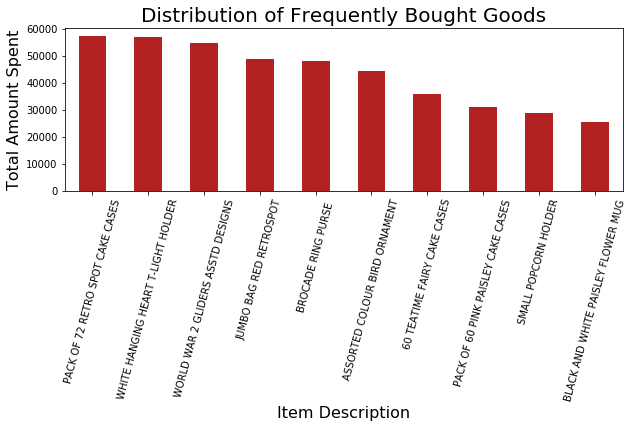

In [0]:
# plotting the distribution of frequently bought goods
st = stock_frq.reset_index()

plt.figure(figsize=(10,3))
stock_frq.head(10).plot.bar(color='firebrick')
plt.bar(stock_frq.head(10),height=0.5 ,color='firebrick' )

plt.xlabel("Item Description",fontsize=16)
plt.xticks(rotation=75)
plt.ylabel("Total Amount Spent",fontsize=16)

plt.title("Distribution of Frequently Bought Goods", fontsize=20)
plt.show()

In [0]:
# getting the number of invoices per month

# grouping the dataframe by year and month
month_grp = retail_cl.sort_values('invoicedate').groupby(['invoiceyear', 'invoicemonth'])

month_inv = month_grp['invoice'].unique().agg(np.size)
month_inv

invoiceyear  invoicemonth
2009         12              1512
2010         1               1011
             2               1104
             3               1524
             4               1329
             5               1377
             6               1497
             7               1381
             8               1293
             9               1689
             10              2133
             11              2587
             12               776
Name: invoice, dtype: int64

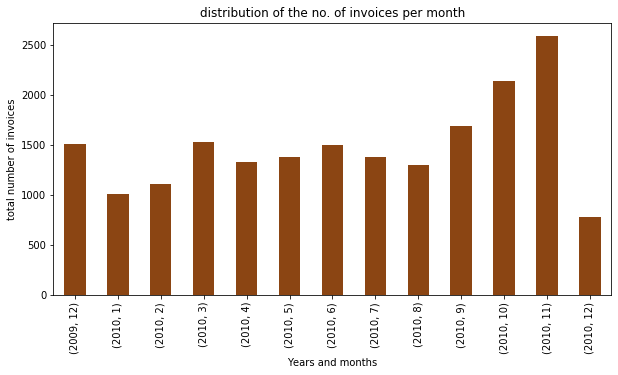

In [0]:
# plotting the distribution of the no. of invoices per month
plt.figure(figsize=(10,5))
month_inv.plot.bar(color='saddlebrown')

plt.title("distribution of the no. of invoices per month")
plt.xlabel("Years and months")
plt.ylabel("total number of invoices")
plt.show()


In [0]:
# total amount spent per month
mamount_grp = month_grp['totalamount'].agg(np.sum)
mamount_grp

invoiceyear  invoicemonth
2009         12               686654.160
2010         1                557319.062
             2                506371.066
             3                699608.991
             4                594609.192
             5                599985.790
             6                639066.580
             7                591636.740
             8                604242.650
             9                831615.001
             10              1036680.000
             11              1172336.042
             12               311878.000
Name: totalamount, dtype: float64

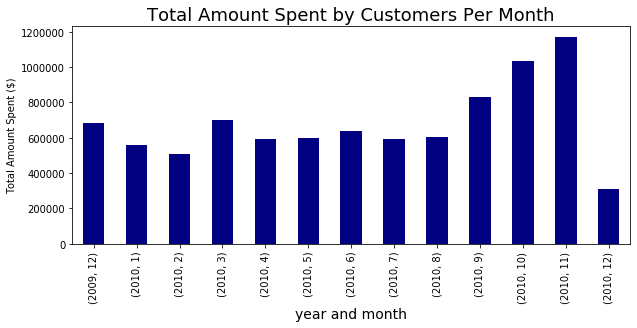

In [0]:
plt.figure(figsize=(10,4))
mamount_grp.plot.bar(color='navy')
plt.title("Total Amount Spent by Customers Per Month", fontsize=18)
plt.xlabel("year and month", fontsize=14)
plt.ylabel("Total Amount Spent ($)")
plt.show()

In [0]:
# Reaarnging counties based on the amount they spent.
country_grp = retail_cl.groupby('country')

ct_grp = country_grp['totalamount'].agg(np.sum).sort_values(ascending=False)
ct_grp
# United kingdom spent more than any other country
#  The least was Nigeria

country
United Kingdom          7.414756e+06
EIRE                    3.560852e+05
Netherlands             2.687860e+05
Germany                 2.023953e+05
France                  1.462154e+05
Sweden                  5.317139e+04
Denmark                 5.090685e+04
Spain                   4.760142e+04
Switzerland             4.392139e+04
Australia               3.144680e+04
Belgium                 2.455708e+04
Channel Islands         2.454632e+04
Norway                  2.394418e+04
Portugal                2.384541e+04
Italy                   1.506718e+04
Greece                  1.433567e+04
Austria                 1.341433e+04
Cyprus                  1.138975e+04
Japan                   9.722020e+03
Finland                 7.379460e+03
United Arab Emirates    7.300410e+03
Unspecified             5.946580e+03
Malta                   5.373500e+03
Lithuania               4.892680e+03
USA                     4.786470e+03
Singapore               4.037770e+03
Poland                  3.5678

In [0]:
# totla number of customers per country
country_grp['customerid'].unique().agg(np.size).sort_values(ascending=False)

country
United Kingdom          3969
Germany                   67
France                    47
Spain                     25
Netherlands               22
Portugal                  18
Belgium                   17
Sweden                    16
Australia                 15
Switzerland               14
Italy                     11
Channel Islands           11
Austria                   10
Denmark                    9
Cyprus                     7
Finland                    7
Japan                      6
USA                        6
Norway                     5
EIRE                       5
Unspecified                4
United Arab Emirates       4
Greece                     4
Bahrain                    2
Korea                      2
Israel                     2
Poland                     2
Iceland                    1
Lithuania                  1
Malta                      1
Nigeria                    1
Canada                     1
Brazil                     1
RSA                        1
Singap

In [0]:
# exploring info on the united kingdom as most customers reside there

uk_custam = retail_cl[retail_cl['country'] == 'United Kingdom'].groupby('customerid')['totalamount'].agg(np.sum).sort_values(ascending=False)
uk_custam.head(10)


customerid
18102    349164.35
13694    131443.19
17511     84541.17
15061     83284.38
16684     80489.21
16754     65500.07
17949     60117.60
13089     57912.03
15311     56003.26
17450     52422.30
Name: totalamount, dtype: float64

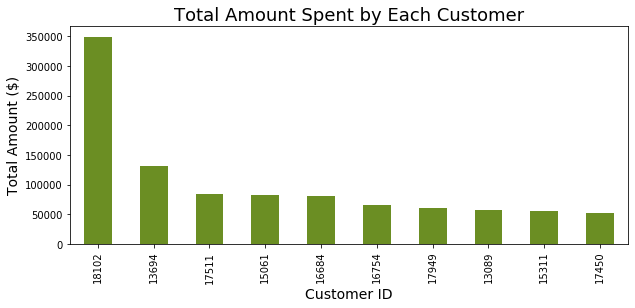

In [0]:
# customer id and amount spent by each

plt.figure(figsize=(10,4))
uk_custam.head(10).plot.bar(color='olivedrab')
plt.title("Total Amount Spent by Each Customer", fontsize=18)
plt.xlabel("Customer ID", fontsize=14)
plt.ylabel("Total Amount ($)", fontsize=14)
plt.show()

In [0]:
# Frequency of the most sold  items
uk_stock = retail_cl[retail_cl['country'] == 'United Kingdom'].groupby('description')
stock_com = uk_stock['quantity'].agg(np.sum).sort_values(ascending=False)
stock_com.head(10)

description
WHITE HANGING HEART T-LIGHT HOLDER    51679
WORLD WAR 2 GLIDERS ASSTD DESIGNS     51538
BROCADE RING PURSE                    48014
PACK OF 72 RETRO SPOT CAKE CASES      45025
JUMBO BAG RED RETROSPOT               43829
ASSORTED COLOUR BIRD ORNAMENT         41529
60 TEATIME FAIRY CAKE CASES           27410
SMALL POPCORN HOLDER                  26135
PACK OF 60 PINK PAISLEY CAKE CASES    25461
PACK OF 12 SUKI TISSUES               23912
Name: quantity, dtype: int64

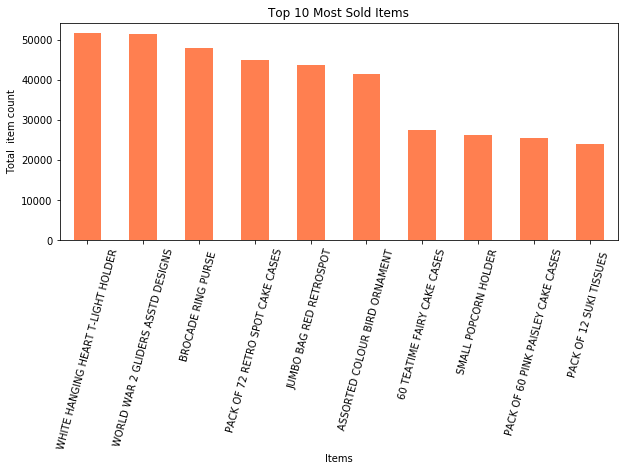

In [0]:
plt.figure(figsize=(10,4))
stock_com.head(10).plot.bar(color='coral')

plt.title("Top 10 Most Sold Items")
plt.xlabel("Items")
plt.xticks(rotation=75)
plt.ylabel("Total  item count")
plt.show()

In [0]:
# frequently sold items by total amount
ukstock_amount = uk_stock['totalamount'].agg(np.sum).sort_values(ascending=False)
ukstock_amount.head(10)

description
WHITE HANGING HEART T-LIGHT HOLDER     137970.11
REGENCY CAKESTAND 3 TIER               123195.60
JUMBO BAG RED RETROSPOT                 76739.55
ASSORTED COLOUR BIRD ORNAMENT           65770.65
Manual                                  53464.76
DOOR MAT UNION FLAG                     39408.73
ROTATING SILVER ANGELS T-LIGHT HLDR     38541.15
PAPER CHAIN KIT 50'S CHRISTMAS          36056.90
RED RETROSPOT CAKE STAND                33997.69
VINTAGE UNION JACK BUNTING              33283.46
Name: totalamount, dtype: float64

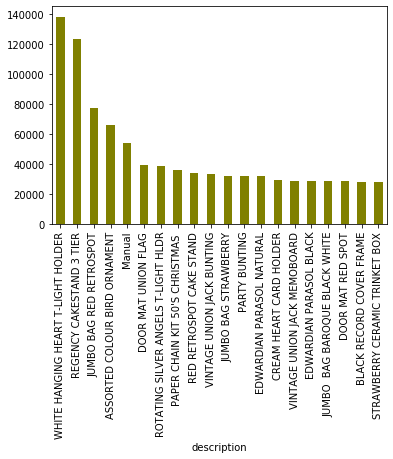

In [0]:
ukstock_amount.head(20).plot.bar(color='olive')
plt.show()

In [0]:
# getting association rules
len(retail_cl[retail_cl['description'].isnull()])

# 0 missing values in the description column

0

In [0]:
#
for i, d in retail_cl[retail_cl['description'].isnull()].iterrows():
  retail_cl['description'][i] = 'Code-' + str(d['stockcode'])
  
retail_cl.head()

,invoice,stockcode,description,quantity,invoicedate,price,customerid,country,totalamount,invoiceyear,invoicemonth,invoiceyearmonth
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,83.4,2009,12,2009-12
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0,2009,12,2009-12
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0,2009,12,2009-12
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,100.8,2009,12,2009-12
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,30.0,2009,12,2009-12


In [0]:
len(retail_cl[retail_cl['description'] == retail_cl['stockcode'].map(lambda x: 'Code-'+str(x))])

0

### Clustering

In [0]:
# using rfm for clustering
import datetime

ref_date = retail_cl.invoicedate.max() + datetime.timedelta(days = 1)
print('Reference Date:', ref_date)

retail_cl['days_since_last_purchase'] = (ref_date - retail_cl.invoicedate).astype('timedelta64[D]')
cust_history =  retail_cl[['customerid', 'days_since_last_purchase']].groupby("customerid").min().reset_index()
cust_history.rename(columns={'days_since_last_purchase':'recency'}, inplace=True)
cust_history.describe().transpose()

Reference Date: 2010-12-10 20:01:00


,count,mean,std,min,25%,50%,75%,max
customerid,4312.0,15349.290353,1701.200176,12346.0,13882.5,15350.5,16834.25,18287.0
recency,4312.0,91.171846,96.860633,1.0,18.0,53.0,136.00,374.0


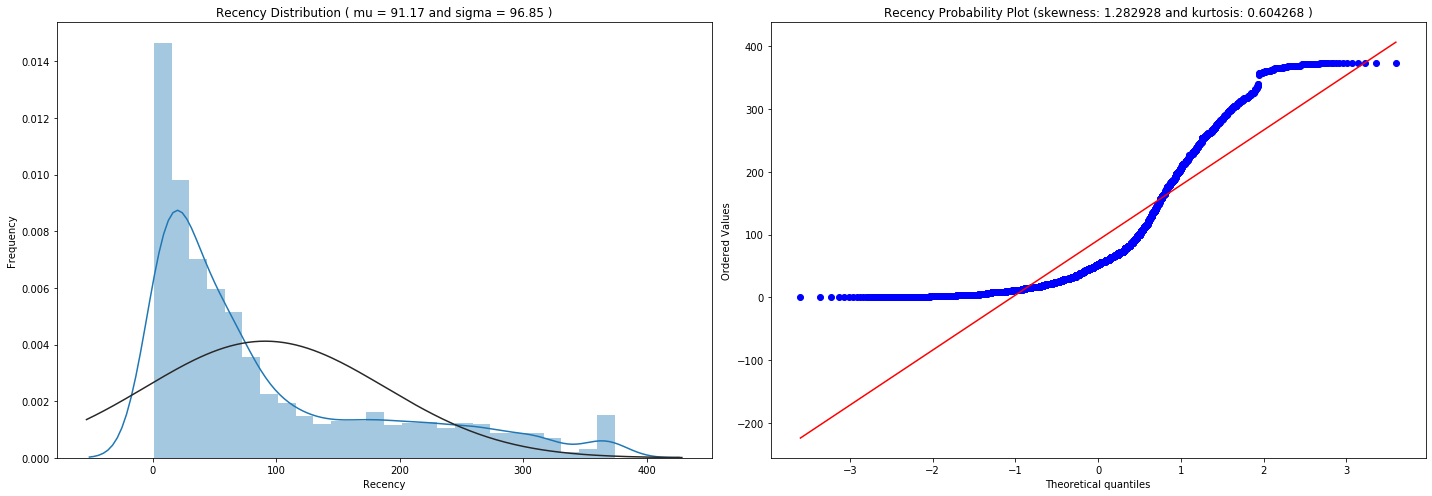

In [0]:
from scipy.stats import norm, probplot, skew

def QQ_plot(data, measure):
    fig = plt.figure(figsize=(20,7))

    #Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(data)

    #Kernel Density plot
    fig1 = fig.add_subplot(121)
    sns.distplot(data, fit=norm)
    fig1.set_title(measure + ' Distribution ( mu = {:.2f} and sigma = {:.2f} )'.format(mu, sigma), loc='center')
    fig1.set_xlabel(measure)
    fig1.set_ylabel('Frequency')

    #QQ plot
    fig2 = fig.add_subplot(122)
    res = probplot(data, plot=fig2)
    fig2.set_title(measure + ' Probability Plot (skewness: {:.6f} and kurtosis: {:.6f} )'.format(data.skew(), data.kurt()), loc='center')

    plt.tight_layout()
    plt.show()

QQ_plot(cust_history.recency, 'Recency')

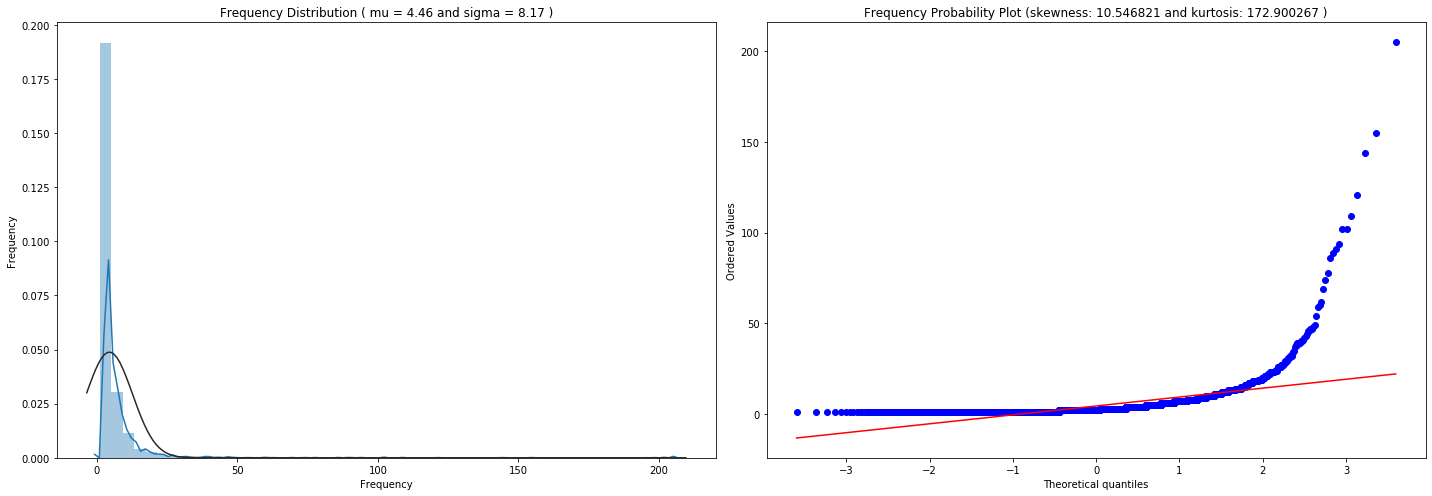

In [0]:
# frequency
cust_freq = (retail_cl[['customerid', 'invoice']].groupby(["customerid", 'invoice']).count().reset_index()).\
                groupby(["customerid"]).count().reset_index()
cust_freq.rename(columns={'invoice':'frequency'},inplace=True)
cust_history = cust_history.merge(cust_freq)
QQ_plot(cust_history.frequency, 'Frequency')



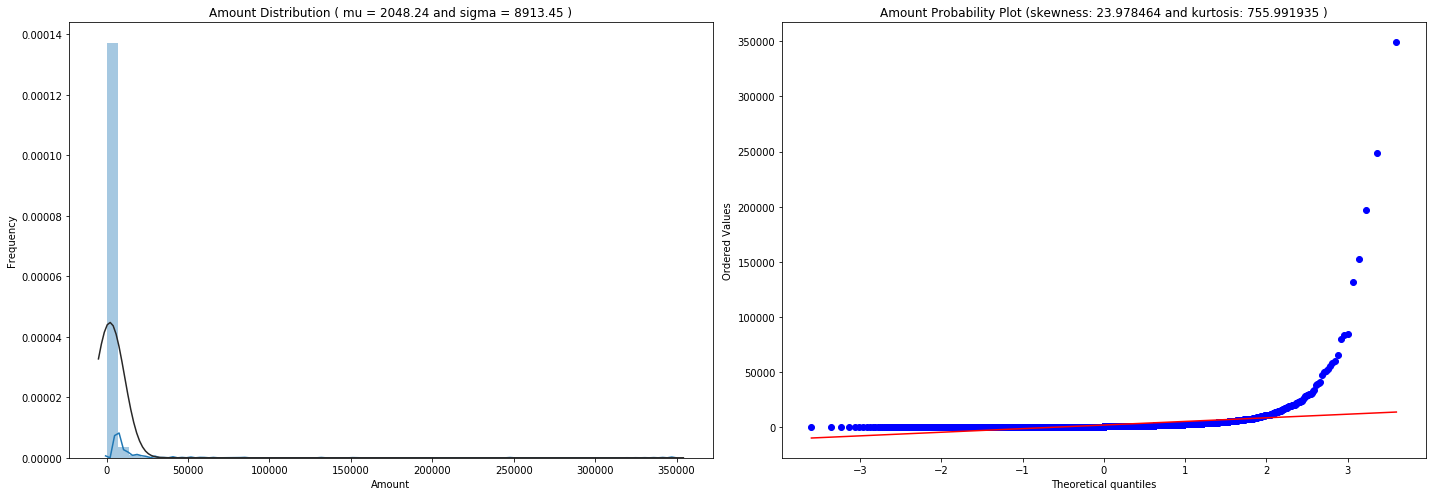

In [0]:
# monetary value
cust_monetary_val = retail_cl[['customerid', 'totalamount']].groupby("customerid").sum().reset_index()
cust_history = cust_history.merge(cust_monetary_val)
QQ_plot(cust_history.totalamount, 'Amount')

In [0]:
# scaling the data to mitigate against bias towards observations of greater magnitude
from sklearn.preprocessing import StandardScaler
import math

cust_history['recency_log'] = cust_history['recency'].apply(math.log)
cust_history['frequency_log'] = cust_history['frequency'].apply(math.log)
cust_history['amount_log'] = cust_history['totalamount'].apply(math.log)
feature_vector = ['amount_log', 'recency_log','frequency_log']
X_subset = cust_history[feature_vector] #.as_matrix()
scaler = StandardScaler().fit(X_subset)
X_scaled = scaler.transform(X_subset)
pd.DataFrame(X_scaled, columns=X_subset.columns).describe().T

,count,mean,std,min,25%,50%,75%,max
amount_log,4312.0,-8.627916e-17,1.000116,-4.308935,-0.687703,-0.041414,0.653705,4.791557
recency_log,4312.0,1.594015e-16,1.000116,-2.731442,-0.651673,0.125385,0.803463,1.531361
frequency_log,4312.0,-2.539970e-17,1.000116,-1.079079,-1.079079,-0.315366,0.694208,4.785842


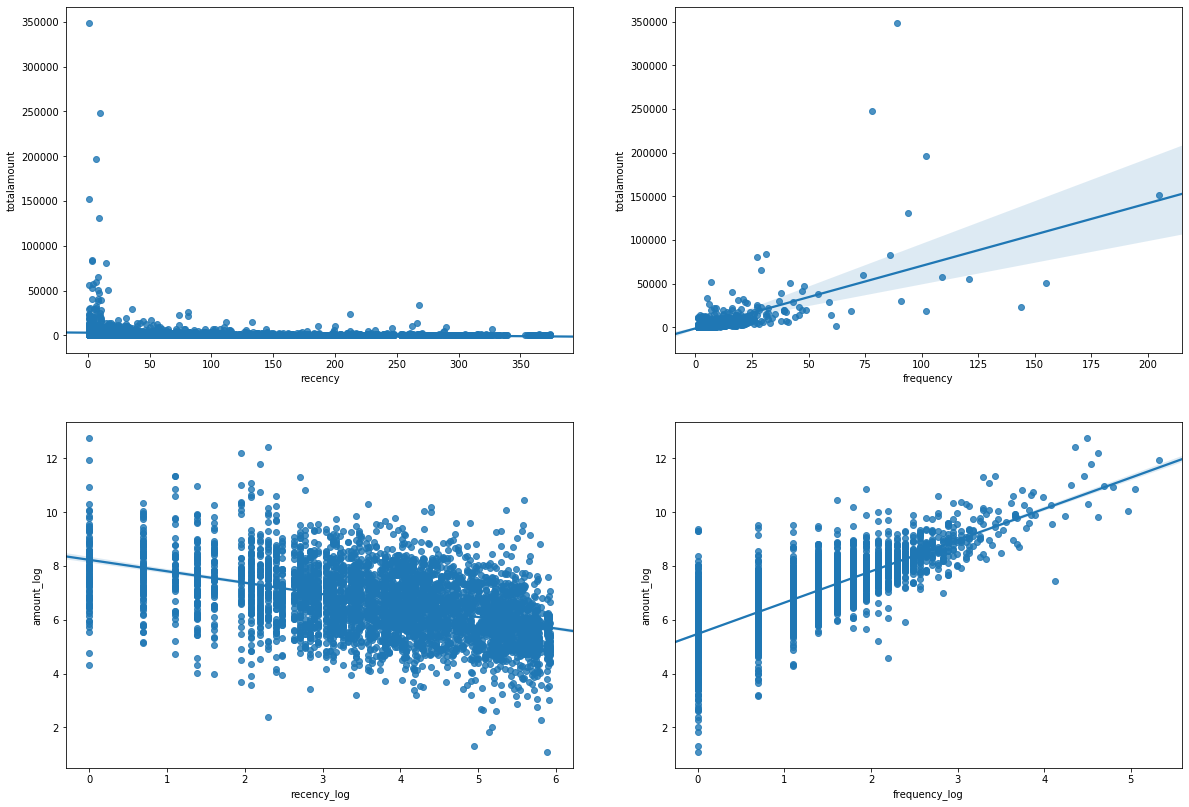

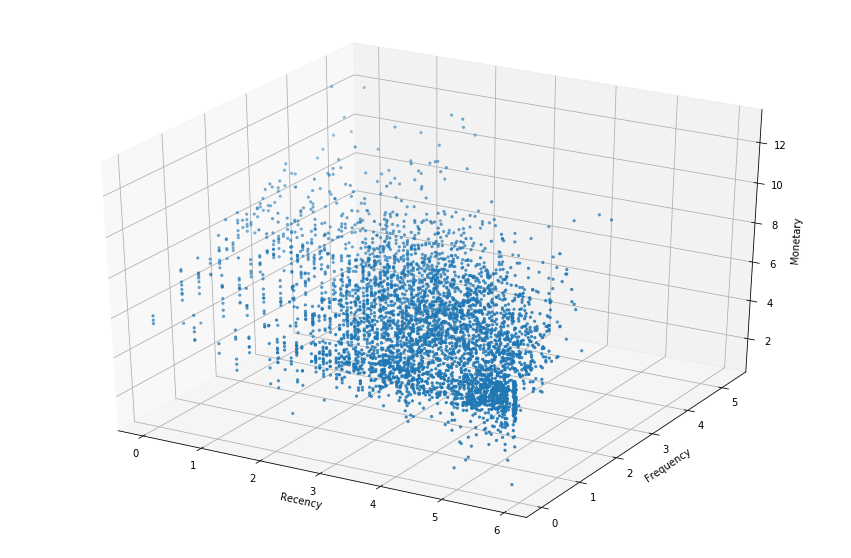

In [0]:
from mpl_toolkits.mplot3d import Axes3D

# plotting regplots(scatter plots and a linear regression line of fit)
fig = plt.figure(figsize=(20,14))
f1 = fig.add_subplot(221); sns.regplot(x='recency', y='totalamount', data=cust_history)
f1 = fig.add_subplot(222); sns.regplot(x='frequency', y='totalamount', data=cust_history)
f1 = fig.add_subplot(223); sns.regplot(x='recency_log', y='amount_log', data=cust_history)
f1 = fig.add_subplot(224); sns.regplot(x='frequency_log', y='amount_log', data=cust_history)

# plotting a 3d scatter plot
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

xs = cust_history.recency_log
ys = cust_history.frequency_log
zs = cust_history.amount_log
ax.scatter(xs, ys, zs, s=5)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

plt.show()

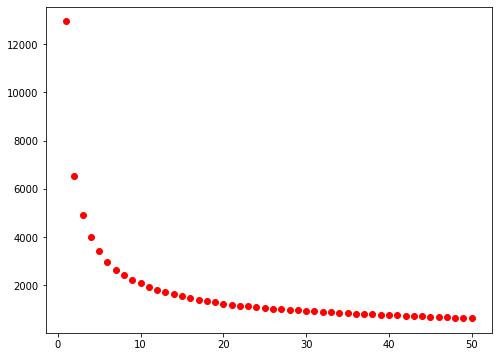

The best K sugest:  7


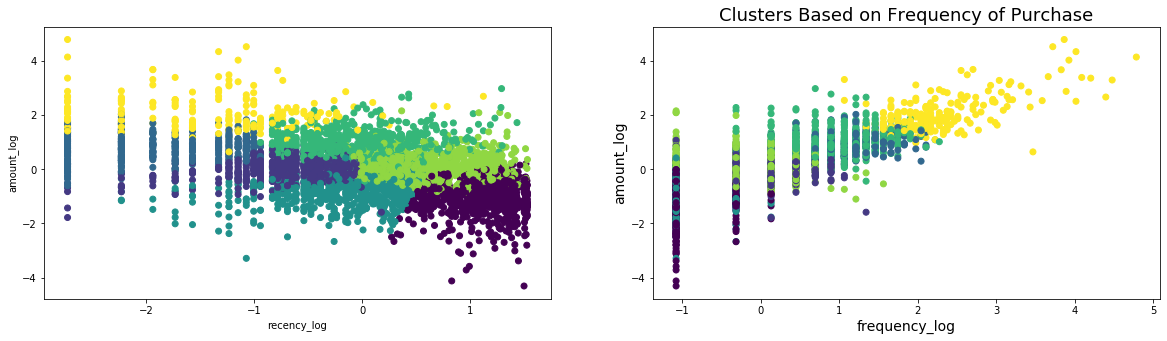

In [0]:
# clustering using kmeans
from sklearn.cluster import KMeans

cl = 50
corte = 0.1

anterior = 100000000000000
cost = [] 
K_best = cl

for k in range (1, cl+1):
    # Create a kmeans model on our data, using k clusters.  random_state helps ensure that the algorithm returns the same results each time.
    model = KMeans(
        n_clusters=k, 
        init='k-means++', #'random',
        n_init=10,
        max_iter=300,
        tol=1e-04,
        random_state=101)

    model = model.fit(X_scaled)

    # These are our fitted labels for clusters -- the first cluster has label 0, and the second has label 1.
    labels = model.labels_
 
    # Sum of distances of samples to their closest cluster center
    interia = model.inertia_
    if (K_best == cl) and (((anterior - interia)/anterior) < corte): K_best = k - 1
    cost.append(interia)
    anterior = interia

plt.figure(figsize=(8, 6))
plt.scatter(range (1, cl+1), cost, c='red')
plt.show()

# Create a kmeans model with the best K.
print('The best K sugest: ',K_best)
model = KMeans(n_clusters=K_best, init='k-means++', n_init=10,max_iter=300, tol=1e-04, random_state=101)

# Note I'm scaling the data to normalize it! Important for good results.
model = model.fit(X_scaled)

# These are our fitted labels for clusters -- the first cluster has label 0, and the second has label 1.
labels = model.labels_

# And we'll visualize it:
#plt.scatter(X_scaled[:,0], X_scaled[:,1], c=model.labels_.astype(float))
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(121)
plt.scatter(x = X_scaled[:,1], y = X_scaled[:,0], c=model.labels_.astype(float))
ax.set_xlabel(feature_vector[1])
ax.set_ylabel(feature_vector[0])
ax = fig.add_subplot(122)
plt.scatter(x = X_scaled[:,2], y = X_scaled[:,0], c=model.labels_.astype(float))
ax.set_xlabel(feature_vector[2], fontsize=14)
ax.set_ylabel(feature_vector[0], fontsize=14)
ax.set_title('Clusters Based on Frequency of Purchase', fontsize=18)

plt.show()

### Market Basket Analysis

In [0]:

grp_inv = retail_cl.groupby('invoice')


transactions = []

for i, group in grp_inv:
  transactions.append(list(group['description'].map(str)))
  

In [0]:
!pip install apyori

  Created wheel for apyori: filename=apyori-1.1.1-cp36-none-any.whl size=5972 sha256=081a173907af1408f5456a16a9f55b6b100049a3792bb94423990b65b8cecdff
  Stored in directory: /root/.cache/pip/wheels/7b/2a/35/c0c3749c1a36d4f454ea22d8396e1b854b86340d63cbbb7949
Successfully built apyori


In [0]:
from apyori import apriori

ass_rules = apriori(transactions, min_support = 0.005, min_confidence = 0.2, min_lift =3, min_length=2)

# getting the results
results = list(ass_rules)

In [0]:
# visualizing 

fin_results = pd.DataFrame(np.random.randint(low=0, high=1, size=(len(results), 6)), columns=['GeneralRules', 'LeftRules', 'RightRules', 'Support', 'Confidence', 'Lift'])

index = 0

for i,j,k in results:
  fin_results.iloc[index] = [' && '.join(list(i)), ' && '.join(list(k[0][0])), ' && '.join(list(k[0][1])), j, k[0][2], k[0][3]]
  index += 1
  
# most significant rules
fin_results = fin_results.sort_values('Lift', ascending=0)
fin_results.head(20)

,GeneralRules,LeftRules,RightRules,Support,Confidence,Lift
160,CAST IRON HOOK GARDEN FORK && CAST IRON HOOK G...,CAST IRON HOOK GARDEN FORK,CAST IRON HOOK GARDEN TROWEL,0.006402,0.878571,124.117595
220,CHILDS GARDEN BRUSH BLUE && CHILDS GARDEN BRUS...,CHILDS GARDEN BRUSH BLUE,CHILDS GARDEN BRUSH PINK,0.005465,0.714286,98.025510
124,PINK FELT EASTER EGG BASKET && BLUE FELT EASTE...,BLUE FELT EASTER EGG BASKET,PINK FELT EASTER EGG BASKET,0.005986,0.793103,96.442383
1185,CHILDS GARDEN FORK PINK && CHILDRENS GARDEN GL...,CHILDRENS GARDEN GLOVES PINK && CHILDS GARDEN ...,CHILDS GARDEN FORK PINK,0.005309,0.962264,94.326434
127,BLUE OWL SOFT TOY && PINK OWL SOFT TOY,BLUE OWL SOFT TOY,PINK OWL SOFT TOY,0.005049,0.769841,90.742088
204,CHILDRENS GARDEN GLOVES BLUE && CHILDRENS GARD...,CHILDRENS GARDEN GLOVES BLUE,CHILDRENS GARDEN GLOVES PINK,0.007807,0.877193,87.778692
988,SILK PURSE BABUSHKA RED && SILK PURSE RUSSIAN ...,SILK PURSE BABUSHKA RED,SILK PURSE RUSSIAN DOLL BLUE,0.005049,0.563953,86.681907
1180,CHILDS GARDEN FORK PINK && CHILDRENS GARDEN GL...,CHILDRENS GARDEN GLOVES BLUE && CHILDS GARDEN ...,CHILDS GARDEN FORK PINK,0.005101,0.875000,85.772321
1492,PACK OF 6 SKULL PAPER PLATES && PACK OF 20 SKU...,PACK OF 20 SKULL PAPER NAPKINS && PACK OF 6 SK...,PACK OF 6 SKULL PAPER PLATES,0.006610,0.913669,85.630848
221,CHILDS GARDEN FORK PINK && CHILDS GARDEN FORK ...,CHILDS GARDEN FORK BLUE,CHILDS GARDEN FORK PINK,0.008276,0.850267,83.347894


In [0]:
count = 1

for a, b in fin_results.head(20).iterrows():
  print('Rule '+str(count)+':')
  print(b['LeftRules'])
  print('=> '+b['RightRules'])
  print('Support: '+str(b['Support'])+' - Confidence: '+ \
        str(b['Confidence']) + ' - Lift: '+str(b['Lift']))
  print('===='*20)
  count += 1

Rule 1:
CAST IRON HOOK GARDEN FORK
=> CAST IRON HOOK GARDEN TROWEL
Support: 0.006401915369801696 - Confidence: 0.8785714285714284 - Lift: 124.11759453781511
Rule 2:
CHILDS GARDEN BRUSH BLUE
=> CHILDS GARDEN BRUSH PINK
Support: 0.005465049705928278 - Confidence: 0.7142857142857143 - Lift: 98.02551020408163
Rule 3:
BLUE FELT EASTER EGG BASKET
=> PINK FELT EASTER EGG BASKET
Support: 0.005985530630302399 - Confidence: 0.793103448275862 - Lift: 96.44238323876036
Rule 4:
CHILDRENS GARDEN GLOVES PINK && CHILDS GARDEN FORK BLUE 
=> CHILDS GARDEN FORK PINK
Support: 0.005308905428616041 - Confidence: 0.9622641509433962 - Lift: 94.32643434732384
Rule 5:
BLUE OWL SOFT TOY
=> PINK OWL SOFT TOY
Support: 0.005048664966428981 - Confidence: 0.7698412698412699 - Lift: 90.74208783717985
Rule 6:
CHILDRENS GARDEN GLOVES BLUE
=> CHILDRENS GARDEN GLOVES PINK
Support: 0.007807213865611826 - Confidence: 0.8771929824561404 - Lift: 87.77869152046785
Rule 7:
SILK PURSE BABUSHKA RED
=> SILK PURSE RUSSIAN DOLL BLUE

In [0]:
fin_results.iterrows()

<generator object DataFrame.iterrows at 0x7f32e0a02db0>

In interprating our results we aim at

1.Support greater than or equal to min_support

2.Confidence greater than or equal to min_confidence

From our results we can conclude that our findings are great in making our decisions as the rules will be stronger in that in the output it satisfies the fact that the confidence and support are all greater than the min_support and min_confidence. looking at the lift it is within the range defined.

Taking a summary of our results the std is very very small which means aor rules are strong enough to drive any decision we need to make even to the point of coming up with a reccommender system.